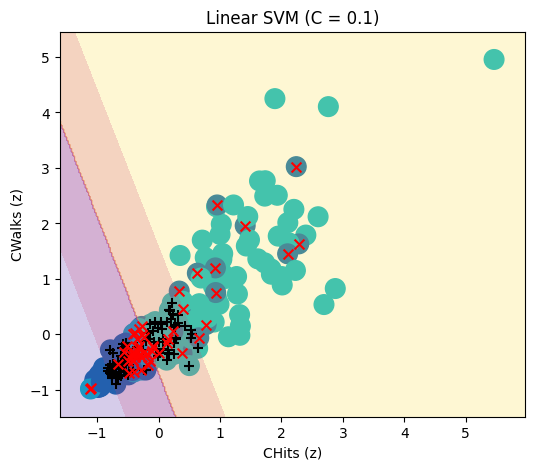

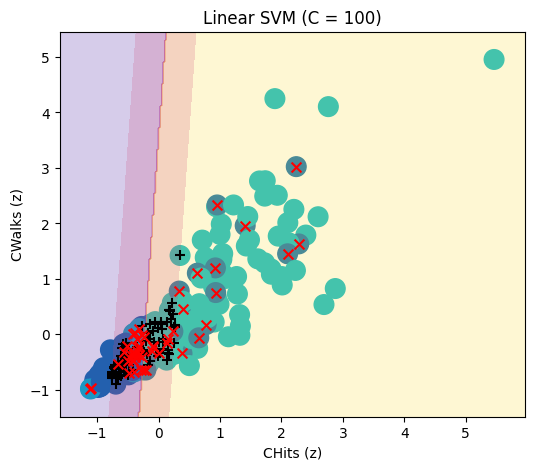

C = 0.1  #Support Vectors: 148
C = 100  #Support Vectors: 128


In [12]:
#Problem1 
from ISLP import load_data
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
import matplotlib.pyplot as plt
import pandas as pd

#Load data and build X, y
Hitters = load_data('Hitters').dropna()
Hitters['High'] = (Hitters['Salary'] > Hitters['Salary'].median()).astype(int)
X = Hitters[['CHits', 'CWalks']]
y = Hitters['High']

#Reset indices to avoid KeyError in plot_svm
X_ = X.reset_index(drop=True).copy()
y_ = y.reset_index(drop=True).copy()

#Standardize features
scaler = StandardScaler()
Xz = pd.DataFrame(scaler.fit_transform(X_), columns=X_.columns)

#Fit linear SVMs with different C
svc_low  = SVC(kernel='linear', C=0.1).fit(Xz.values, y_.values)   # strong regularization (wider margin)
svc_high = SVC(kernel='linear', C=100).fit(Xz.values, y_.values)   # weak regularization (narrower margin)

#Plot decision boundaries (standardized space)
fig, ax = plt.subplots(figsize=(6,5))
plot_svm(pd.DataFrame(Xz, columns=['CHits','CWalks']), y_, svc_low, ax=ax)
ax.set_title('Linear SVM (C = 0.1)')
ax.set_xlabel('CHits (z)'); ax.set_ylabel('CWalks (z)')
plt.show()

fig, ax = plt.subplots(figsize=(6,5))
plot_svm(Xz, y_, svc_high, ax=ax)
ax.set_title('Linear SVM (C = 100)')
ax.set_xlabel('CHits (z)'); ax.set_ylabel('CWalks (z)')
plt.show()

#Report # of support vectors
print("C = 0.1  #Support Vectors:", len(svc_low.support_))
print("C = 100  #Support Vectors:", len(svc_high.support_))


# Problem1

The colored background shows the decision regions of the linear SVM in standardized CHits–CWalks space.

The two main colors (yellow and purple) represent areas that the model classifies as high- and low-salary players.

The shaded transition area between them corresponds to the margin, where the model is less confident.

## Answer
When C = 0.1, the SVM allows more margin violations, resulting in a wider margin and 148 support vectors. The decision boundary is smoother and less sensitive to noise.

When C = 100, the model penalizes misclassification more heavily, creating a narrower margin with 128 support vectors. The boundary fits the training data more closely, showing greater flexibility but potentially higher variance.

This experiment helps determine how the cost parameter C controls the trade-off between model simplicity and accuracy.

A smaller C leads to a wider margin and better generalization, while a larger C produces a narrower margin and higher model flexibility but may overfit the training data.

Best C: 10
Best 5-fold CV accuracy: 0.8139

All CV results:
     C  mean_CV_acc  std_CV_acc  mean_train_acc  std_train_acc
  0.01     0.703338    0.033629        0.704405       0.018828
  0.10     0.806241    0.046221        0.806107       0.018883
  1.00     0.810160    0.048381        0.813717       0.022518
 10.00     0.813933    0.055991        0.816574       0.021068
100.00     0.813933    0.055991        0.816574       0.021068


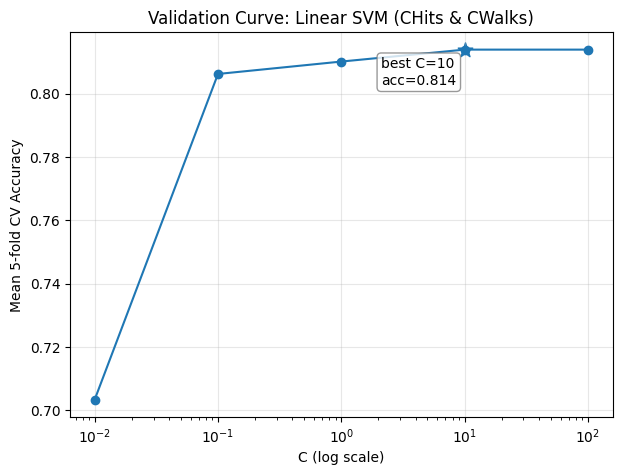

In [13]:
#Problem2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from ISLP import load_data  

#Data (same as Q1) 
Hitters = load_data('Hitters').dropna()
Hitters['High'] = (Hitters['Salary'] > Hitters['Salary'].median()).astype(int)
X = Hitters[['CHits','CWalks']].reset_index(drop=True)
y = Hitters['High'].reset_index(drop=True)

#GridSearchCV over C (linear SVM)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='linear'))
])

param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100]}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gscv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

gscv.fit(X, y)

#Report best results 
best_C = gscv.best_params_['svc__C']
best_cv_acc = gscv.best_score_

print(f"Best C: {best_C}")
print(f"Best 5-fold CV accuracy: {best_cv_acc:.4f}")

#Summarize all mean CV scores into a table 
res = pd.DataFrame(gscv.cv_results_)
#only keep relevant columns
table = res[['param_svc__C', 'mean_test_score', 'std_test_score',
             'mean_train_score', 'std_train_score']].copy()
table = table.sort_values('param_svc__C')
table.rename(columns={
    'param_svc__C': 'C',
    'mean_test_score': 'mean_CV_acc',
    'std_test_score': 'std_CV_acc',
    'mean_train_score': 'mean_train_acc',
    'std_train_score': 'std_train_acc'
}, inplace=True)

print("\nAll CV results:")
print(table.to_string(index=False))

#Validation curve: accuracy vs C (log-scale X) 
xs = table['C'].astype(float).values
ys = table['mean_CV_acc'].values

plt.figure(figsize=(7,5))
plt.plot(xs, ys, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean 5-fold CV Accuracy')
plt.title('Validation Curve: Linear SVM (CHits & CWalks)')

# show best C
best_idx = np.argmax(ys)
plt.scatter([xs[best_idx]], [ys[best_idx]], s=120, marker='*')
plt.annotate(f"best C={xs[best_idx]:g}\nacc={ys[best_idx]:.3f}",
             (xs[best_idx], ys[best_idx]),
             textcoords="offset points", xytext=(-60,-25), ha='left',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.grid(True, alpha=0.3)
plt.show()


# Problem2
We performed a 5-fold cross-validation grid search over C=[0.01,0.1,1,10,100] for a linear SVM using standardized CHits and CWalks.

The highest mean CV accuracy (0.814) occurred at C = 10, indicating that this value provides the best trade-off between margin width and classification accuracy.

Accuracy increases rapidly as C grows from 0.01 to 0.1 (reducing underfitting) and then plateaus beyond C = 10, suggesting that larger C values offer no additional generalization benefit.

The validation curve (log-scale x-axis) visualizes this trend, with the best C clearly marked by the star.

RBF SVM (C=1, gamma=1) -> Train Acc: 0.940 | Test Acc: 0.880


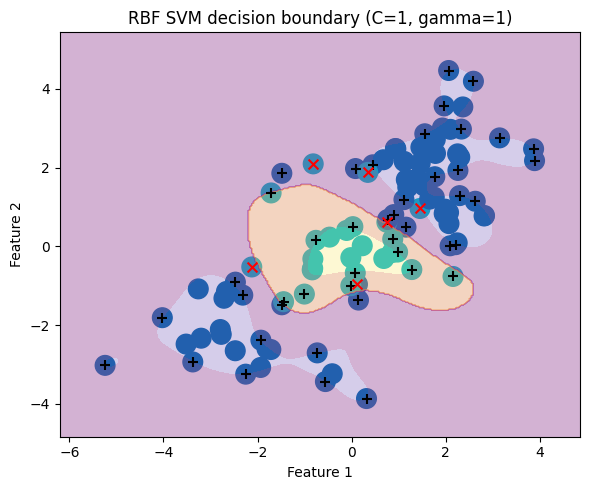

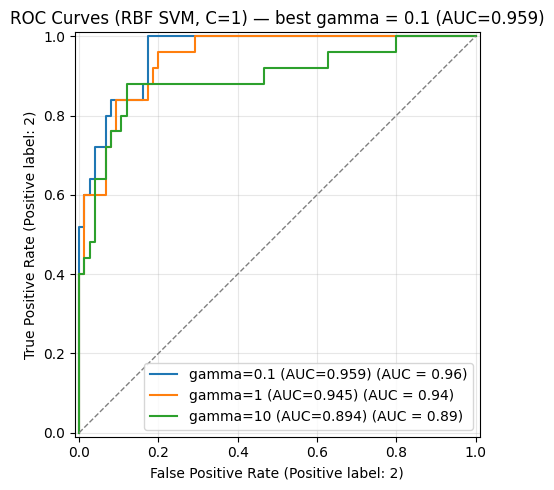

gamma=0.1  -> Train Acc: 0.900 | Test Acc: 0.900 | Test AUC: 0.959
gamma=1    -> Train Acc: 0.940 | Test Acc: 0.880 | Test AUC: 0.945
gamma=10   -> Train Acc: 0.960 | Test Acc: 0.860 | Test AUC: 0.894


In [14]:
#Problem3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from ISLP.svm import plot as plot_svm

#Generate synthetic data
np.random.seed(42)
X = np.random.randn(200, 2)
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150 + [2]*50)

#Split 50/50
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1, stratify=y
)

#RBF SVM (C=1, gamma=1): boundary plot
rbf_g1 = SVC(kernel='rbf', C=1, gamma=1)
rbf_g1.fit(X_train, y_train)

train_acc = rbf_g1.score(X_train, y_train)
test_acc  = rbf_g1.score(X_test,  y_test)
print(f"RBF SVM (C=1, gamma=1) -> Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

fig, ax = plt.subplots(figsize=(6,5))
plot_svm(X_train, y_train, rbf_g1, ax=ax)
ax.set_title("RBF SVM decision boundary (C=1, gamma=1)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
plt.tight_layout()
plt.show()

#Combined ROC curves for gamma = 0.1, 1, 10 
gammas = [0.1, 1, 10]
aucs = {}
models = {}

fig, ax = plt.subplots(figsize=(7,5))  #all ROC curves share this ax

for g in gammas:
    clf = SVC(kernel='rbf', C=1, gamma=g)
    clf.fit(X_train, y_train)
    models[g] = clf

    scores = clf.decision_function(X_test)
    y_test_bin = (y_test == 2).astype(int)
    aucs[g] = roc_auc_score(y_test_bin, scores)

    RocCurveDisplay.from_estimator(
        clf, X_test, y_test, name=f"gamma={g} (AUC={aucs[g]:.3f})", 
        pos_label=2, ax=ax  #all curves drawn on the same axes
    )

best_gamma = max(aucs, key=aucs.get)
ax.plot([0,1],[0,1],'--',linewidth=1,color='gray')
ax.set_title(f"ROC Curves (RBF SVM, C=1) — best gamma = {best_gamma} (AUC={aucs[best_gamma]:.3f})")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Summary
for g in gammas:
    tr = models[g].score(X_train, y_train)
    te = models[g].score(X_test,  y_test)
    print(f"gamma={g:<4} -> Train Acc: {tr:.3f} | Test Acc: {te:.3f} | Test AUC: {aucs[g]:.3f}")


# Problem3
Generated a synthetic non-linear dataset and fitted RBF SVMs with C = 1 and gamma {0.1, 1, 10}.

The model with gamma = 0.1 achieved the highest test AUC (0.959), indicating the best generalization performance.

Smaller gamma values produce smoother, less complex decision boundaries, while larger gamma values yield highly flexible, wiggly boundaries that can overfit the training data.

Thus, gamma = 0.1 provides the optimal balance between model flexibility and generalization.